# Kernel Density Estimation Examples for Various Cases

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import qmcpy as qp
import pandas as pd
from scipy import stats
from simple_colors import *
from copy import deepcopy
import sympy as sy
import sympy.stats
import pickle
#!pip install UniformSumDistribution
from UniformSumDistribution import UniformSumDistribution
figpath = 'KDE_Ex_Output/' #this path sends the figures to the directory that you want
fig_format = 'pdf'

## What we still need to do
* Plot error versus n
* Plot h versus n
* Correct for finite bounds on $Y$
* Try kernels with higher accuracies
* Include conditional Monte Carlo
* Can we do a kde without for loops (done)
* Compute times
* fix git

### Some LaTeX macros (hidden in math mode)
$
\newcommand{\vt}{\boldsymbol{t}}
\newcommand{\vx}{\boldsymbol{x}}
\newcommand{\vX}{\boldsymbol{X}}
\newcommand{\cf}{\mathcal{F}}
\newcommand{\cu}{\mathcal{U}}
\newcommand{\dif}{\mathrm{d}}
\newcommand{\Ex}{\mathbb{E}}
\DeclareMathOperator{\disc}{disc}
\newcommand{\norm}[2][{}]{{\left \lVert #2 \right \rVert}_{#1}}
$

## Set Up Functions of Uniform Random Variables and Their Densities

### A dictionary for each $f$

#### Weighted sum of Gaussians is a Gaussian

In [53]:
def sum_d_Gauss_case(): #Sum of Gaussian random variables
    def fullwts(d = 1,coord_wts = 1):
        fw = coord_wts[:np.min([d,coord_wts.shape[0]])] * np.ones(d) #expand the weights to fit the dimension
        stdev = np.sqrt(np.sum(fw**2))  #square root of sum of squares of weights
        return fw, stdev
    def f(x,d = 1,coord_wts = 1):   #is there a way to avoid having to use squeeze
        if d == 1:
            return np.squeeze(sp.stats.norm.ppf(x) * fullwts(d,coord_wts)[0])
        else:
            return np.squeeze(np.sum(sp.stats.norm.ppf(x) * fullwts(d,coord_wts)[0], axis = -1))
    def density(y,d = 1,coord_wts = 1):
        return sp.stats.norm.pdf(y, scale = fullwts(d,coord_wts)[1])
    return {"f" : f,       #return a dictionary
            "density" : density,  #probability density of f(X) where X is IID U([0,1]^d)
            "y_plt_domain" : lambda d,coord_wts : np.array([-3.,3.])*fullwts(d,coord_wts)[1],  #domain for plotting the density
            "y_domain" : lambda d, coord_wts : np.array([float("-inf"),float("inf")]),  #sample space of Y = f(X)
            "name" : lambda d,coord_wts : f"Weighted Sum of {d:.0f} Gaussians",  #Plot label for density
            "d_allowed" : [float('inf')]
    }
sum_d_Gauss_case()["y_plt_domain"](1,np.array([1,1]))

array([-3.,  3.])

#### Weighted sum of uniforms is an [Irwin-Hall distribution](https://en.wikipedia.org/wiki/Irwin–Hall_distribution)

In [54]:
def sum_d_unif_case(): #Sum of uniform random variables
    def f(x,d = 1,coord_wts = 1):
        assert x.ndim > 1
        return x.sum(axis = -1)
    def density(y,d = 1,coord_wts = 1):
        return UniformSumDistribution(d).pdf(y)
    return {"f" : f,       #return a dictionary
            "density" : density,  #probability density of f(X) where X is IID U([0,1]^d)
            "y_plt_domain" : lambda d,coord_wts : np.array([-0.1,d+0.1]),  #domain for plotting the density
            "y_domain" : lambda d, coord_wts : np.array([0,d]),  #sample space of Y = f(X)
            "name" : lambda d,coord_wts : f"Weighted Sum of {d:.0f} uniforms",  #Plot label for density
            "d_allowed" : [float('inf')]
    }

d = 1
x = np.random.rand(8,d)
print("x =",x)
y = sum_d_unif_case()["f"](x,d)
print("y has shape",y.shape,"and values ",y)
sum_d_unif_case()["y_plt_domain"](1,np.array([1,1]))

x = [[0.59669874]
 [0.29887619]
 [0.9099877 ]
 [0.60082861]
 [0.24950243]
 [0.0545541 ]
 [0.72201455]
 [0.32035127]]
y has shape (8,) and values  [0.59669874 0.29887619 0.9099877  0.60082861 0.24950243 0.0545541
 0.72201455 0.32035127]


array([-0.1,  1.1])

#### Put the cases together

In [37]:
ex_densities = [sum_d_unif_case(),sum_d_Gauss_case()]
#ex_densities = [sum_d_unif_case()]
dens_kwargs = {"d" : 5, "coord_wts" : np.array(range(1,11))**-2.}
print(ex_densities[1]["y_plt_domain"](**dens_kwargs))
dens_kwargs = {"d" : 2, "coord_wts" : np.array(range(1,11))**-2.}
print(ex_densities[0]["f"](np.array([[0.5,0.4],]),**dens_kwargs))
print(ex_densities[0]["f"](np.array([[0.5,0.4],[0.2,0.3]]),**dens_kwargs))
print(ex_densities[1]["f"](np.array([[0.5,0.4],]),**dens_kwargs))
print(ex_densities[1]["f"](np.array([[0.5,0.4],[0.2,0.3]]),**dens_kwargs))

[-3.11819938  3.11819938]
[0.9]
[0.9 0.5]
-0.06333677578394993
[-0.06333678 -0.97272136]


## Set up sampling schemes

In [38]:
samplers = [{"gen_sample" : lambda d, n : qp.IIDStdUniform(d).gen_samples(n),
            "sample_name" : "IID"},
           {"gen_sample" : lambda d, n : qp.Sobol(d).gen_samples(n),
            "sample_name" : "Sobol'"},
           {"gen_sample" : lambda d, n : qp.Lattice(d).gen_samples(n),
            "sample_name" : "lattice"},          
           {"gen_sample" : lambda d, n : qp.Halton(d).gen_samples(n),
            "sample_name" : "Halton"}]

## Define a kernel density estimator

In [39]:
def kdeold(kernel, ydata, yeval = np.array([0]), bandwidth = 1):
    kernel_val = np.exp(-((ydata.reshape(len(ydata),1) - yeval.reshape(1,len(yeval)))/bandwidth)**2)/(bandwidth*np.sqrt(np.pi))
    return np.mean(kernel_val,axis = 0) 

def kde(ydata, yeval = np.array([0]), 
          kernel = {"name" : "Gauss", "bandwidth" : 1, "domain" : np.array([float('-inf'), float('inf')])}):  #a kernel for kernel density estimation(KDE)
    '''
        kernel = the choice of kernel
        ydata = the observations of Y used to construct the KDE
        yeval = the values of y where the density is to be approximated
        bandwidth = the bandwidth of the kernel
        domain = (a,b) = sample space of Y
    '''
    h = kernel["bandwidth"]
    a = kernel["domain"][0]
    b = kernel["domain"][1]
    n_data = len(ydata)
    n_eval = len(yeval)
    if kernel["name"] == "Gauss":
        kernel_val = np.exp(-((ydata.reshape(n_data,1) - yeval.reshape(1,n_eval))/h)**2)
        normal_fac_vals = (sp.special.erf((b-ydata)/h) - sp.special.erf((a-ydata)/h))/2
        kernel_val = kernel_val / normal_fac_vals.reshape(n_data,1)  #correction to the kernel for the restricted sample space
        domain_window = ((yeval >= a) & (yeval <= b))  #restricted sample space
        #print(domain_window)
    return np.mean(kernel_val,axis = 0)*domain_window/(h*np.sqrt(np.pi))

ndata = 1000
neval = 10
bandwidth = 0.1
kernel = {"name" : "Gauss", 
          "bandwidth" : 0.1, 
          "domain" : np.array([0,1])}
ydata = qp.IIDStdUniform(1).gen_samples(ndata)
yeval = np.linspace(-0.1,1.1,neval)
print("yeval = ",yeval)
#print(kernelbd(np.array([-1, 0, 1])))
#print(kernel(ydata,yeval,bandwidth))
#print(kde(ydata, yeval))
print(kdebd(ydata, yeval, kernel))

def error_rho(rhoexact,rhoapp,h_list,kind_of_err = ["rmse"]):  #Compute different error measures for the KDE
    err_out = dict.fromkeys(kind_of_err)
    ''' 
    In this dictionary output
                          key = kind of error measure
        0th entry in the list = where the best bandwidth occurs
        1st entry in the list = best bandwidth
        2nd entry in the list = best error
        rest of the entries   = errors of all bandwidths
    '''
    err_rho = rhoexact - rhoapp  #pointwise error
    if "rmse" in kind_of_err:  #root mean squared error                           
        rmse = np.sqrt((err_rho**2).mean(1))
        where_min = rmse.argmin()
        err_out["rmse"] = [where_min, h_list[where_min], rmse[where_min], *rmse]
    if "mae" in kind_of_err:  #mean absolute error
        mae = np.abs(err_rho).mean(1)
        where_min = mae.argmin()
        err_out["mae"] = [where_min, h_list[where_min], mae[where_min], *mae]
    if "sup" in kind_of_err:  #supremum or maximum of error
        sup = np.abs(err_rho).max(1)
        where_min = sup.argmin()
        err_out["sup"] = [where_min, h_list[where_min], maxe[where_min], *sup]    
    return err_out

yeval =  [-0.1         0.03333333  0.16666667  0.3         0.43333333  0.56666667
  0.7         0.83333333  0.96666667  1.1       ]
[False  True  True  True  True  True  True  True  True False]
[0.         0.84339453 0.97715777 0.96048623 1.007509   1.08663349
 1.11783214 1.02552203 0.83392045 0.        ]


## Plot results of experiments

### Remember to load the data to plot

In [58]:
wh_err = "mae"
n_rep = 15
n_max = 2**9
d_max = 5
out_filename = f'KDE_Ex_Data_{wh_err:s}_nrep_{n_rep:.0f}_nmax_{n_max:.0f}_dmax_{d_max:.0f}.pkl'
with open(figpath+out_filename,'rb') as myfile: 
    wh_err,n_densities,n_dim,n_samplers,n_n,dim_list,n_list,yplot,rhoexact,rhoapp,err_out_dict,pp_wh_med = pickle.load(myfile) #load in all the data

### Plot densities and their approximations

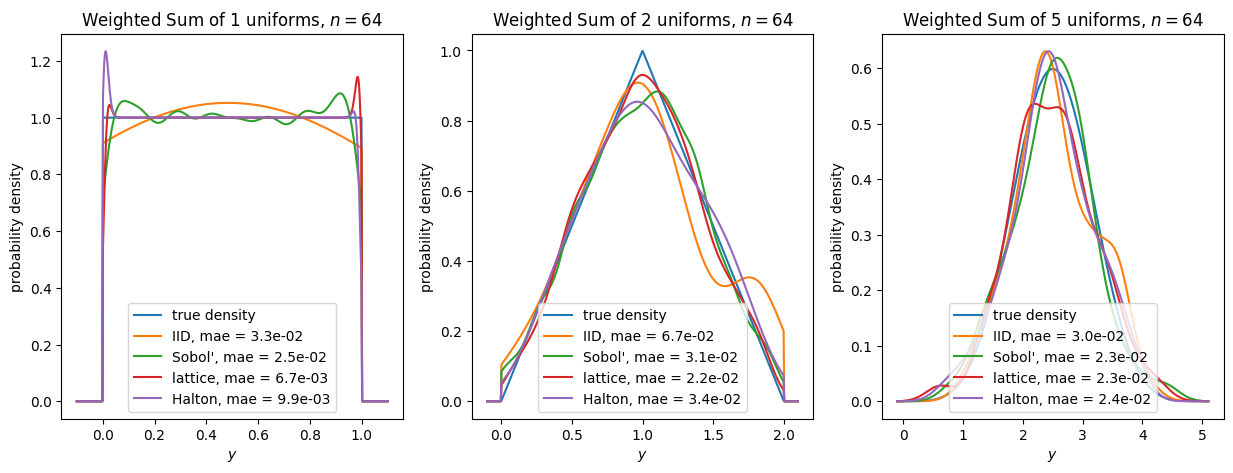

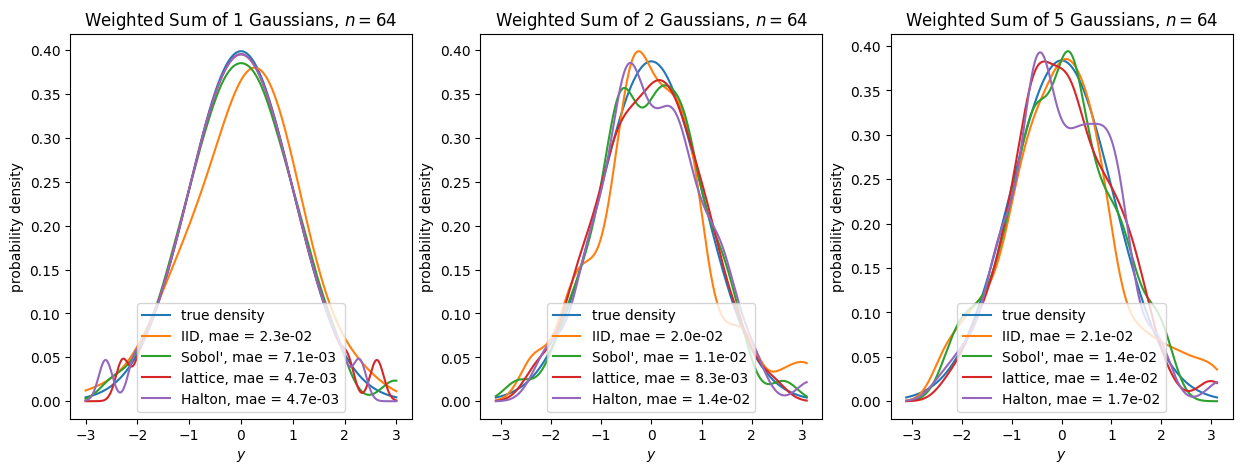

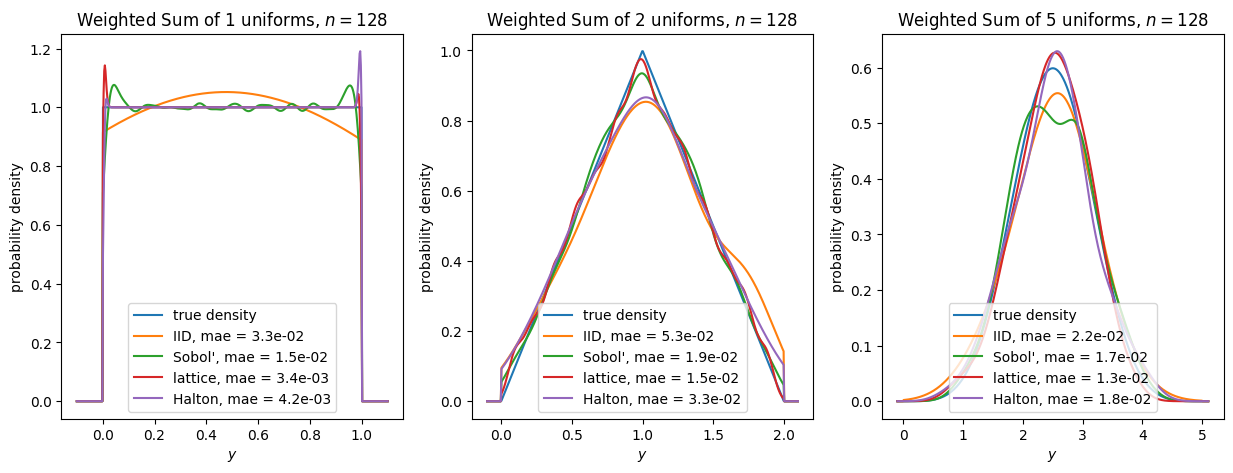

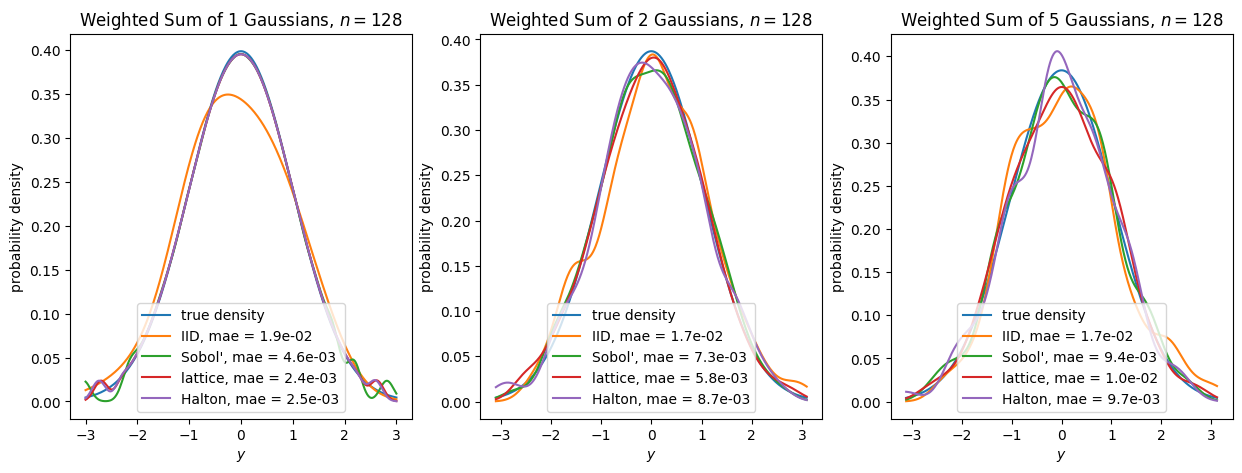

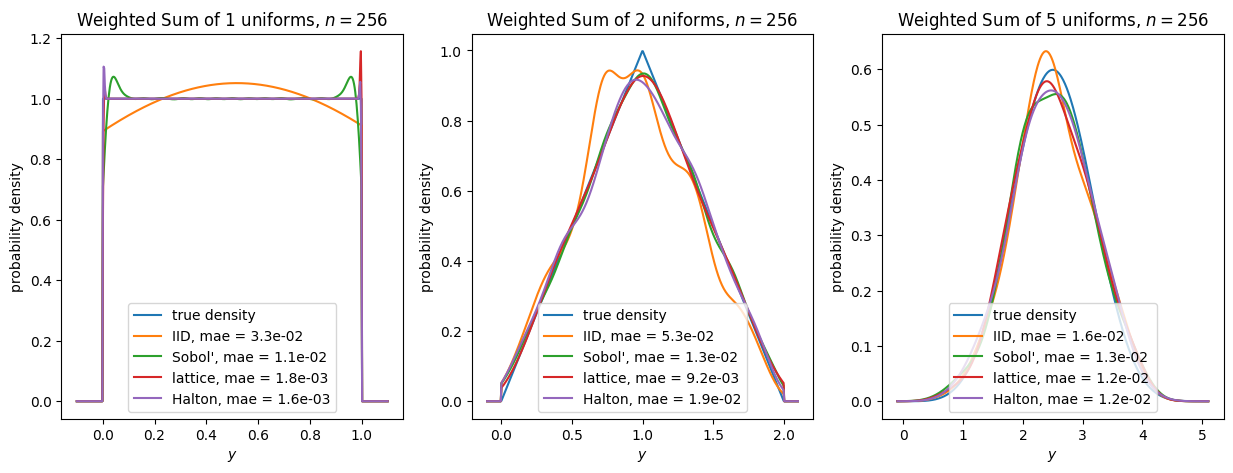

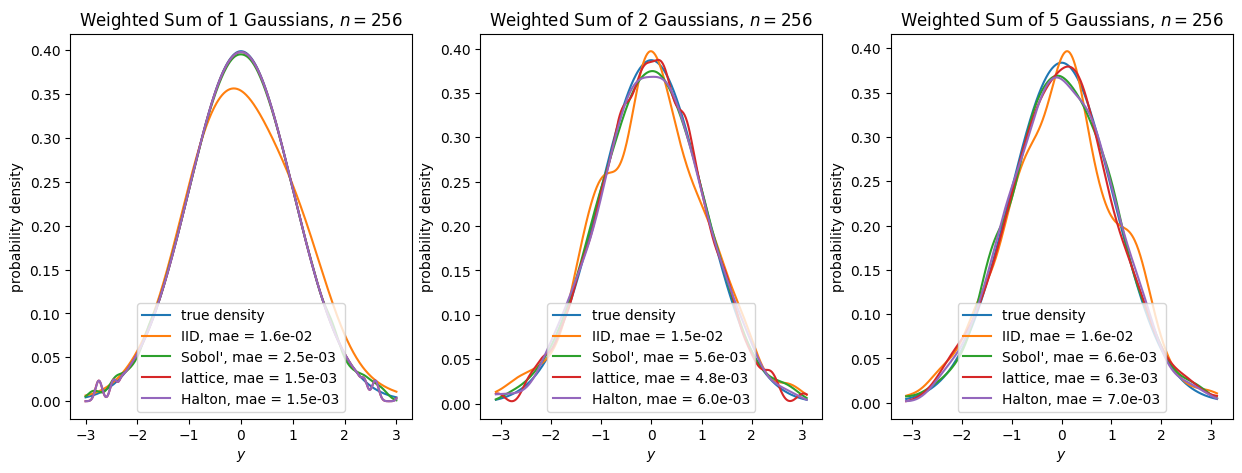

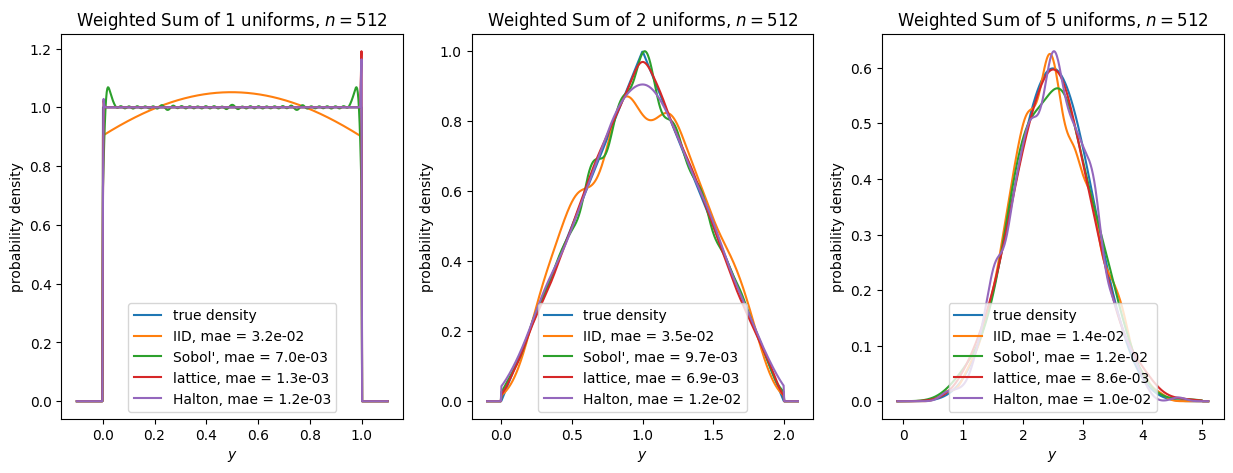

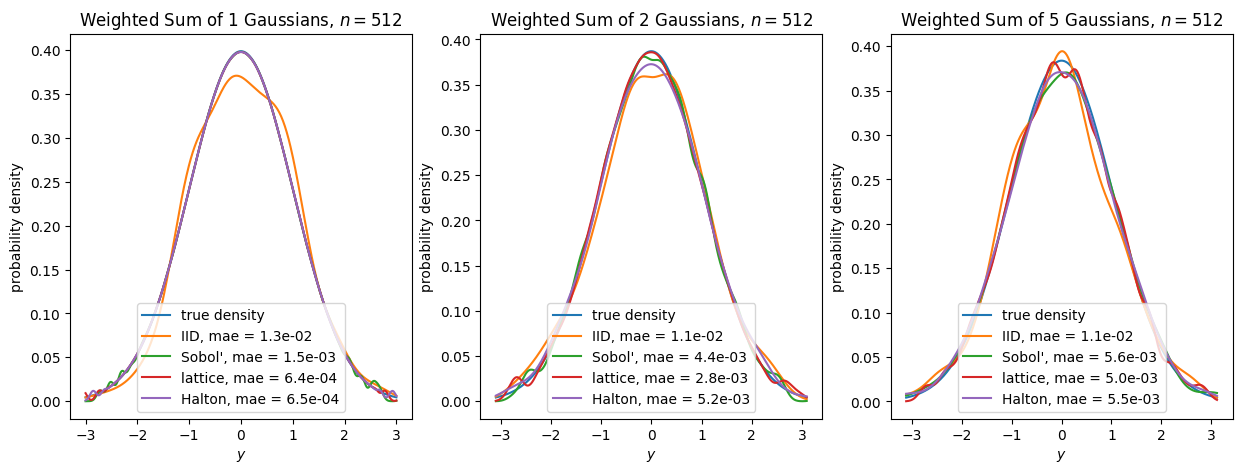

In [59]:
for ll in range(n_n):
    n = n_list[ll]
    for ii in range(n_densities):  #iterate over different f and corresponding densities
        fig,ax = plt.subplots(1,n_dim,figsize = (15,5))
        for kk in range(n_dim):  #iterate over different dimensions
            d = dim_list[kk]
            dens_kwargs["d"] = d
            if (ex_densities[ii]["d_allowed"] == [float('inf')]) or any(d == dd for dd in ex_densities[ii]["d_allowed"]):
                ax[kk].plot(yplot[ii,kk,:], rhoexact[ii,kk,:], label = "true density")
                ax[kk].set_title(f'{ex_densities[ii]["name"](**dens_kwargs):s}, $n = {n:.0f}$')
                ax[kk].set_xlabel("$y$")
                ax[kk].set_ylabel("probability density")  
                for jj in range(n_samplers):  #iterate over different sampling methods
                    pp_plot = pp_wh_med[ii,jj,kk,ll]
                    ax[kk].plot(yplot[ii,kk,:],rhoapp[ii,jj,kk,ll,:], 
                            label = f'{samplers[jj]["sample_name"]}, {wh_err:s} = {best_err[ii,jj,kk,ll]:0.1e}')
                ax[kk].legend(loc="lower center")
        figfilename = f'KDE_Ex_Data_mae_{ex_densities[ii]["name"](**dens_kwargs):s}_nrep_{n_rep:.0f}_n_{n:.0f}_dmax_{d_max:.0f}.{fig_format:s}'
        #fig.savefig(figpath+f'KDE_Ex_Data_mae_{ex_densities[ii]["name"](**dens_kwargs):s}_n_{n:.0f}.eps',format='eps',bbox_inches='tight')        
        fig.savefig(figpath+figfilename,format=fig_format,bbox_inches='tight')

### Plot error vs. n

### Plot h vs. n

## Run numerical experiments and store the data

In [57]:
nplot = 500 #number of points to plot the KDE at
wh_err = "mae"
n_rep = 15 #number of replications

dens_kwargs = {"d" : 1, "coord_wts" : np.array(range(1,11))**-2.}
dim_list = np.array([1, 2, 5])
n_list = 2**np.arange(6,10,dtype=int)
bandwidth_list = 2.**np.arange(-10,1,1)
n_densities = len(ex_densities)  #number of cases of f and densities
n_samplers = len(samplers)  #number of samplers
n_dim = dim_list.shape[0]  #number of dimensions
n_n = n_list.shape[0]  #number of sample sizes
n_bandwidth = bandwidth_list.shape[0]  #number of bandwidths
d_max = dim_list.max()
n_max = n_list.max()

## Initialize large arrays
rhoexact = np.zeros((n_densities,n_dim,nplot))
yplot = np.zeros((n_densities,n_dim,nplot))
rhoapp = np.zeros((n_densities,n_samplers,n_dim,n_n,nplot))
rhoapp_ppmm = np.zeros((n_rep,n_bandwidth,nplot))
err_out_dict = {(ii,jj,kk,ll) : 
        0 for ii in range(n_densities) for jj in range(n_samplers) for kk in range(n_dim) for ll in range(n_n)}
err_out_dict_pp = {pp : 0 for pp in range(n_rep)}
x_all = np.zeros((n_samplers,n_rep,n_max,d_max))   
ypts = np.zeros((n_rep,n_max))
pp_wh_med = np.zeros((n_densities,n_samplers,n_dim,n_n))
best_err = pp_wh_med
best_err_pp = np.zeros(n_rep)


for ii in range(n_densities):  #iterate over different f and corresponding densities
    for jj in range(n_samplers):            # construct the IID and LD nodes
        for pp in range(n_rep):              # n_rep repetitions
            x_all[jj,pp,:,:] = samplers[jj]["gen_sample"](d_max,n_max) 
    for kk in range(n_dim):  #iterate over dimensions
        d = dim_list[kk]
        if (ex_densities[ii]["d_allowed"] == [float('inf')]) or any(d == dd for dd in ex_densities[ii]["d_allowed"]):
            dens_kwargs["d"] = d  #update the dimension
            plt_domain = ex_densities[ii]["y_plt_domain"](**dens_kwargs) 
            print(plt_domain)
            yplot[ii,kk,:] = np.linspace(plt_domain[0],plt_domain[1],nplot)
            rhoexact[ii,kk,:] = ex_densities[ii]["density"](yplot[ii,kk,:],**dens_kwargs)
            h_list = np.diff(plt_domain)[0]*bandwidth_list
            #print(h_list)
            print(yplot[ii,kk,:])
            kernel = {"name" : "Gauss", "bandwidth" : 1, "domain" : ex_densities[ii]["y_domain"](**dens_kwargs)}
            for jj in range(n_samplers):  #iterate over sampling methods
                print(f"density #{ii:.0f}, dimension = {d:.0f}, sampler #{jj:.0f}")
                for pp in range(n_rep):  #iterate over replications
                    ypts[pp,:] = ex_densities[ii]["f"](x_all[jj,pp,:n_max,:d],**dens_kwargs)  #construct all data points for all repetitions                    
                for ll in range(n_n):  #iterate over sample sizes
                    n = n_list[ll]
                    for pp in range(n_rep):  #iterate over replications
                        for mm in range(n_bandwidth):  #iterate over different bandwidths 
                            kernel["bandwidth"] = h_list[mm]
                            rhoapp_ppmm[pp,mm,:] = kde(ypts[pp,:n],yplot[ii,kk,:],kernel)  #kde estimate
                        err_out_dict_pp[pp] = error_rho(rhoexact[ii,kk,:],rhoapp_ppmm[pp,:,:],h_list,kind_of_err = [wh_err])  #optimize bandwidth
                        best_err_pp[pp] = err_out_dict_pp[pp][wh_err][2]
                    #print(best_err)
                    pp_where = np.argsort(best_err_pp)[best_err_pp.shape[0]//2]
                    #print(pp_where)
                    pp_wh_med[ii,jj,kk,ll] = pp_where
                    #print(pp_where)
                    best_err[ii,jj,kk,ll] = best_err_pp[pp_where]
                    err_out_dict[ii,jj,kk,ll] = err_out_dict_pp[pp_where]
                    rhoapp[ii,jj,kk,ll,:] = rhoapp_ppmm[pp_where,err_out_dict_pp[pp_where][wh_err][0]]

out_filename = f'KDE_Ex_Data_{wh_err:s}_nrep_{n_rep:.0f}_nmax_{n_max:.0f}_dmax_{d_max:.0f}.pkl'
with open(figpath+out_filename,'wb') as myfile: 
    pickle.dump([wh_err,n_densities,n_dim,n_samplers,n_n,dim_list,n_list,yplot,rhoexact,rhoapp,err_out_dict,pp_wh_med],myfile)  #save numerical output as a pickle file


[-0.1  1.1]
[-1.00000000e-01 -9.75951904e-02 -9.51903808e-02 -9.27855711e-02
 -9.03807615e-02 -8.79759519e-02 -8.55711423e-02 -8.31663327e-02
 -8.07615230e-02 -7.83567134e-02 -7.59519038e-02 -7.35470942e-02
 -7.11422846e-02 -6.87374749e-02 -6.63326653e-02 -6.39278557e-02
 -6.15230461e-02 -5.91182365e-02 -5.67134269e-02 -5.43086172e-02
 -5.19038076e-02 -4.94989980e-02 -4.70941884e-02 -4.46893788e-02
 -4.22845691e-02 -3.98797595e-02 -3.74749499e-02 -3.50701403e-02
 -3.26653307e-02 -3.02605210e-02 -2.78557114e-02 -2.54509018e-02
 -2.30460922e-02 -2.06412826e-02 -1.82364729e-02 -1.58316633e-02
 -1.34268537e-02 -1.10220441e-02 -8.61723447e-03 -6.21242485e-03
 -3.80761523e-03 -1.40280561e-03  1.00200401e-03  3.40681363e-03
  5.81162325e-03  8.21643287e-03  1.06212425e-02  1.30260521e-02
  1.54308617e-02  1.78356713e-02  2.02404810e-02  2.26452906e-02
  2.50501002e-02  2.74549098e-02  2.98597194e-02  3.22645291e-02
  3.46693387e-02  3.70741483e-02  3.94789579e-02  4.18837675e-02
  4.42885772e

# Stopping here for now

### Hermite functions

#### Constructing a density kernel whose integral is one and whose integral against low order polynomials vanishes

Define a kernel in terms of Hermite polynomials so that integrates to one and integrates to zero for higher order polynomials

In [6]:
y = sy.symbols('y', real = True)
h = sy.symbols('h', positive = True)
def sy_hermite_kernel(y = sy.symbols('y', real = True), band_width = sy.symbols('h', positive = True), r = 1, only_coef = False):
    '''
    band_width = the kernel band width, often denoted h; a smaller bandwidth means a peakier kernel
    r = number of terms in our kernel
    '''
#    import sympy as sy
    wt = sy.exp(-y*y) #normalizing weight for Hermite functions
    k = sy.zeros(r,1) #initialize a vector of bases that make up the kernel
    intk = sy.zeros(r,r) #initialize a matrix of integrals of the bases with respect to even degree polynomials
    for ii in range(r):
        k[ii] = sy.hermite(2*ii,y)*wt #form the bases
        for jj in range(r):
            intk[jj,ii] = sy.integrate(k[ii]*(y**(2*jj)),(y,-sy.oo,sy.oo)) #evaluate the integrals against even degree monomials
    tot_int = sy.Matrix.vstack(sy.ones(1,1),sy.zeros(r-1,1)) #the kernel should integrate to one, 
        #and the kernel integrated against y, y^2, ..., y^r should be zero
#    print(tot_int)
    coef = sy.Matrix(list(sy.linsolve((intk,tot_int)))) #solve the system of equations for the coefficients of the bases
    if only_coef:
        return coef
    print(coef)
#    ktilde = coef.dot(k)
#    integk = sy.integrate(ktilde,(y,-sy.oo,sy.oo))
#    print('integk =',integk)
    ktilde = coef.dot(k.subs(y,y/band_width)/band_width) #form the isotropic kernel and insert the bandwidth dependency
#    integ = sy.integrate(ktilde,(y,-sy.oo,sy.oo))
#    print('integ =',integ)
#    print(band_width)
#    print(ktilde)
    return coef.dot(k.subs(y,y/band_width)/band_width)

In [7]:
test_kernel_sy = sy_hermite_kernel(r=1)
print(type(test_kernel_sy))
print('kernel =',test_kernel_sy)
integ = sy.integrate(test_kernel_sy,(y,-sy.oo,sy.oo))
print('integ =',integ)
test_kernel_sy = sy_hermite_kernel(r=2,only_coef = True)
print(test_kernel_sy)

Matrix([[1/sqrt(pi)]])
<class 'sympy.core.mul.Mul'>
kernel = exp(-y**2/h**2)/(sqrt(pi)*h)
integ = 1
Matrix([[1/sqrt(pi), -1/(4*sqrt(pi))]])


#### Look at this kernel for different values of the order and the bandwidth
A smaller bandwidth makes a peakier kernel

A higher order means that there is potentially higher accuracy, although it may mean that the KDE has negative values

In [8]:
h = sy.symbols('h', positive = True)
y = sy.symbols('y', real = True)
rarray = sy.Matrix([sy.Integer(1), sy.Integer(2), sy.Integer(3)])
nr = rarray.shape[0]

Matrix([[1/sqrt(pi)]])
ktilde = \frac{e^{- y^{2}}}{\sqrt{\pi}}
Matrix([[1/sqrt(pi), -1/(4*sqrt(pi))]])
ktilde = \frac{\left(\frac{3}{2} - y^{2}\right) e^{- y^{2}}}{\sqrt{\pi}}
Matrix([[1/sqrt(pi), -1/(4*sqrt(pi)), 1/(32*sqrt(pi))]])
ktilde = \frac{\left(4 y^{4} - 20 y^{2} + 15\right) e^{- y^{2}}}{8 \sqrt{\pi}}


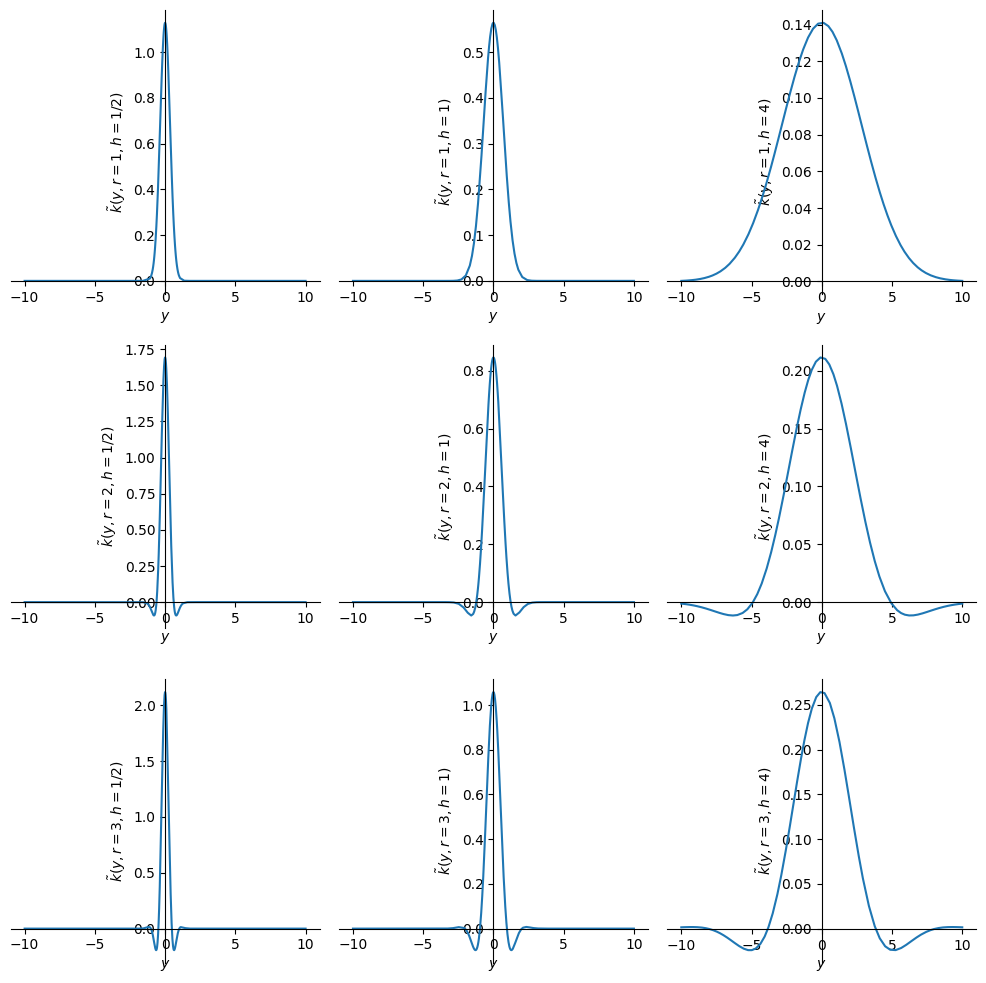

In [9]:
harray = sy.Matrix([sy.Rational(1/2), sy.Rational(1), sy.Rational(4)])
nh = harray.shape[0]
p = [];
for rr in range(nr):
    rval = rarray[rr]
    ktilde_sy = sy.simplify(sy_hermite_kernel(y,h,rval))
    print('ktilde =',sy.latex(ktilde_sy.subs(h,1)))
    for hh in range(nh):
        hval = harray[hh]
        p.append(sy.plot(ktilde_sy.subs(h,hval),ylabel = r'$\tilde k(y,r='+str(rval)+',h='+str(hval)+')$', show = False))
sy.plotting.PlotGrid(nr,nh, *p, size = (10,10));

#### Smoothing a density with respect to these kernels

In [10]:
r = 2
trial_density_sy = sy.stats.density(sy.stats.Normal(x,0,1))(y)
print(trial_density_sy)
ktilde_sy = sy_hermite_kernel(y,h,r)
integ = sy.integrate(ktilde_sy,(y,-sy.oo,sy.oo))
print(integ)
smoothed_density_sy = sy.integrate(trial_density_sy.subs(y,y-z)*ktilde_sy.subs(y,z),(z,-sy.oo,sy.oo))
print(smoothed_density_sy)

sqrt(2)*exp(-y**2/2)/(2*sqrt(pi))
Matrix([[1/sqrt(pi), -1/(4*sqrt(pi))]])
1
3*(2 - erfc(y/(h*sqrt(h**2/2 + 1))))*sqrt(h**2 + 2)*exp(-y**2/h**2)*exp(y**2/(h**2*(h**2/2 + 1)))/(8*sqrt(pi)*(h**2/2 + 1)) + 3*sqrt(h**2 + 2)*exp(-y**2/h**2)*exp(y**2/(h**2*(h**2/2 + 1)))*erfc(y/(h*sqrt(h**2/2 + 1)))/(8*sqrt(pi)*(h**2/2 + 1)) - sqrt(2)*(-sqrt(pi)*h*sqrt(h**2/2 + 1)/(2*y) + sqrt(pi)*(-1/2 - y**2/(h**2*(h**2/2 + 1)))*(-2*h*sqrt(h**2/2 + 1)*exp(-y**2/(h**2*(h**2/2 + 1)))/y - 2*sqrt(pi)*(2 - erfc(y/(h*sqrt(h**2/2 + 1)))))*exp(y**2/(h**2*(h**2/2 + 1)))/2)*exp(-y**2/h**2)/(4*pi**(3/2)*(h**2/2 + 1)**(3/2)) - sqrt(2)*(sqrt(pi)*h*sqrt(h**2/2 + 1)/(2*y) + sqrt(pi)*(-1/2 - y**2/(h**2*(h**2/2 + 1)))*(2*h*sqrt(h**2/2 + 1)*exp(-y**2/(h**2*(h**2/2 + 1)))/y - 2*sqrt(pi)*erfc(y/(h*sqrt(h**2/2 + 1))))*exp(y**2/(h**2*(h**2/2 + 1)))/2)*exp(-y**2/h**2)/(4*pi**(3/2)*(h**2/2 + 1)**(3/2)) - y**2*(2 - erfc(y/(h*sqrt(h**2/2 + 1))))*sqrt(h**2 + 2)*exp(-y**2/h**2)*exp(y**2/(h**2*(h**2/2 + 1)))/(4*sqrt(pi)*h**2*(h**2/2 + 

Matrix([[1/sqrt(pi)]])
Matrix([[1/sqrt(pi), -1/(4*sqrt(pi))]])
Matrix([[1/sqrt(pi), -1/(4*sqrt(pi)), 1/(32*sqrt(pi))]])


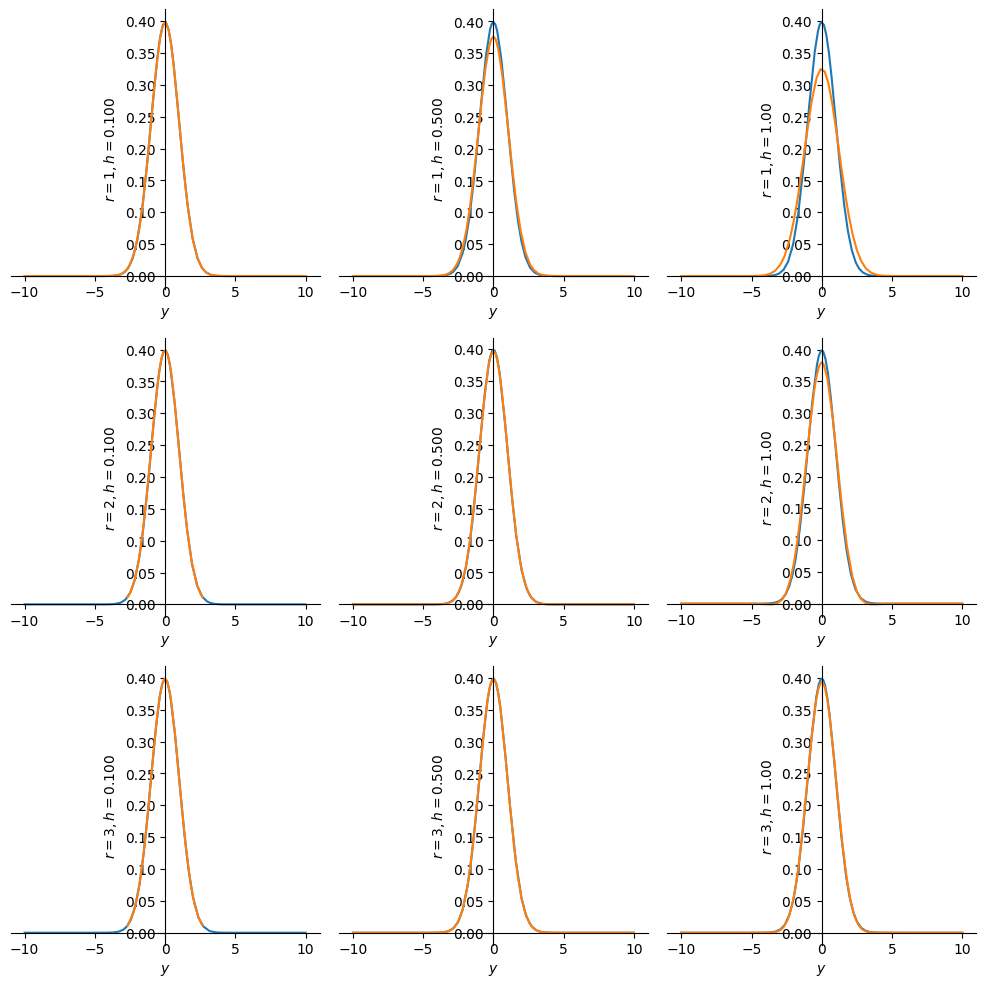

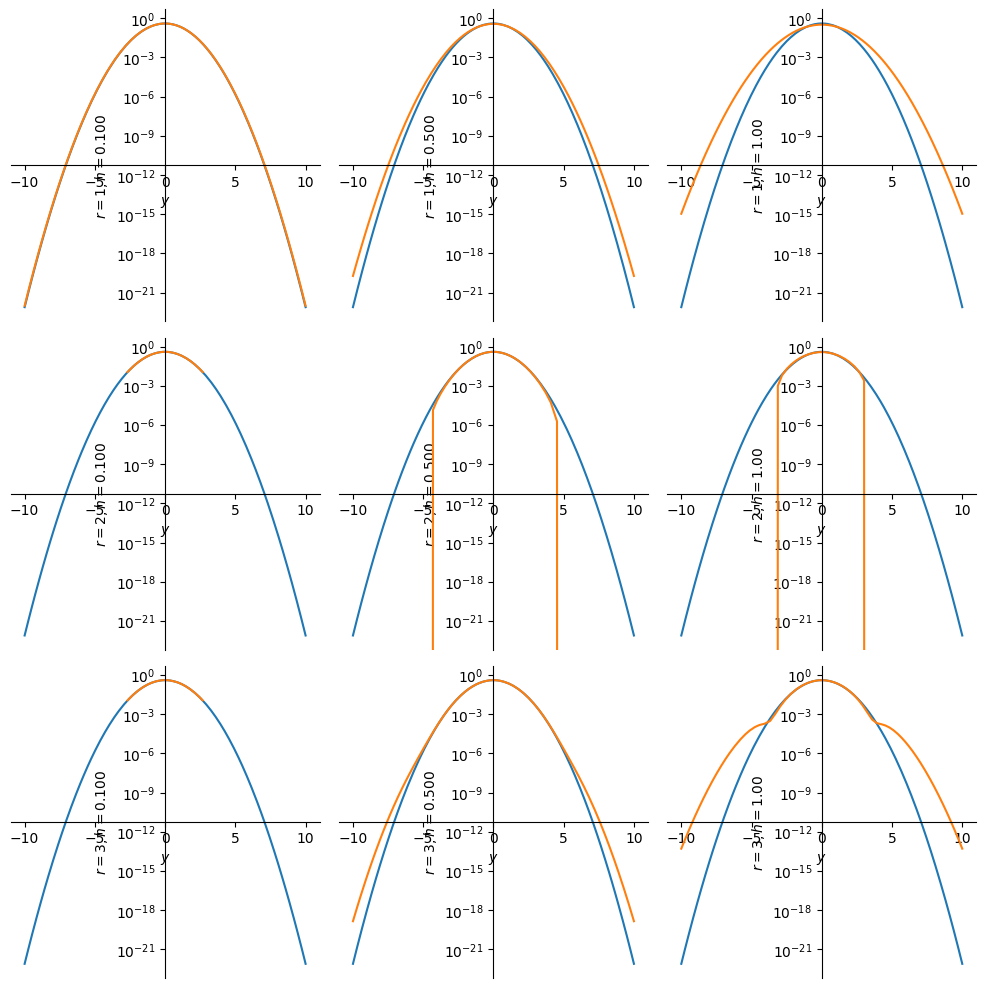

In [11]:
harray = sy.Matrix([sy.Rational(1/10), sy.Rational(1/2), sy.Rational(1)])
nh = harray.shape[0]
p = []
plog = []
for rr in range(nr):
    rval = rarray[rr]
    ktilde_sy = sy_hermite_kernel(y,h,rval)
    smoothed_density_sy = sy.integrate(trial_density_sy.subs(y,y-z)*ktilde_sy.subs(y,z),(z,-sy.oo,sy.oo))
    for hh in range(nh):
        hval = harray[hh]
        p.append(sy.plot(trial_density_sy,smoothed_density_sy.subs(h,hval),ylabel = r'$r='+str(rval)+', h='+str(sy.N(hval,3))+'$', show = False))
        plog.append(sy.plot(trial_density_sy,smoothed_density_sy.subs(h,hval),ylabel = r'$r='+str(rval)+', h='+str(sy.N(hval,3))+'$', yscale = 'log', show = False))
sy.plotting.PlotGrid(nr,nh, *p, size = (10,10));
sy.plotting.PlotGrid(nr,nh, *plog, size = (10,10));

In [12]:
ktilde_sy = sy_hermite_kernel(y,h,1)
ktilde_n = sy.lambdify((y,h),ktilde_sy)
print('ktilde(0,1) =',ktilde_sy.subs([(y,0),(h,1)]),'=',sy.N(ktilde_sy.subs([(y,0),(h,1)])),'=',ktilde_n(0,1))
yval = np.linspace(-3,3,7)
print('yval =',yval)
print(yval.shape)
ktilde_n(yval.reshape(7,1)-yval,1)

Matrix([[1/sqrt(pi)]])
ktilde(0,1) = 1/sqrt(pi) = 0.564189583547756 = 0.5641895835477563
yval = [-3. -2. -1.  0.  1.  2.  3.]
(7,)


array([[5.64189584e-01, 2.07553749e-01, 1.03334927e-02, 6.96265260e-05,
        6.34911734e-08, 7.83543327e-12, 1.30865062e-16],
       [2.07553749e-01, 5.64189584e-01, 2.07553749e-01, 1.03334927e-02,
        6.96265260e-05, 6.34911734e-08, 7.83543327e-12],
       [1.03334927e-02, 2.07553749e-01, 5.64189584e-01, 2.07553749e-01,
        1.03334927e-02, 6.96265260e-05, 6.34911734e-08],
       [6.96265260e-05, 1.03334927e-02, 2.07553749e-01, 5.64189584e-01,
        2.07553749e-01, 1.03334927e-02, 6.96265260e-05],
       [6.34911734e-08, 6.96265260e-05, 1.03334927e-02, 2.07553749e-01,
        5.64189584e-01, 2.07553749e-01, 1.03334927e-02],
       [7.83543327e-12, 6.34911734e-08, 6.96265260e-05, 1.03334927e-02,
        2.07553749e-01, 5.64189584e-01, 2.07553749e-01],
       [1.30865062e-16, 7.83543327e-12, 6.34911734e-08, 6.96265260e-05,
        1.03334927e-02, 2.07553749e-01, 5.64189584e-01]])

#### Computing the quality of merit of the density kernel

Matrix([[1/sqrt(pi), -1/(4*sqrt(pi))]])


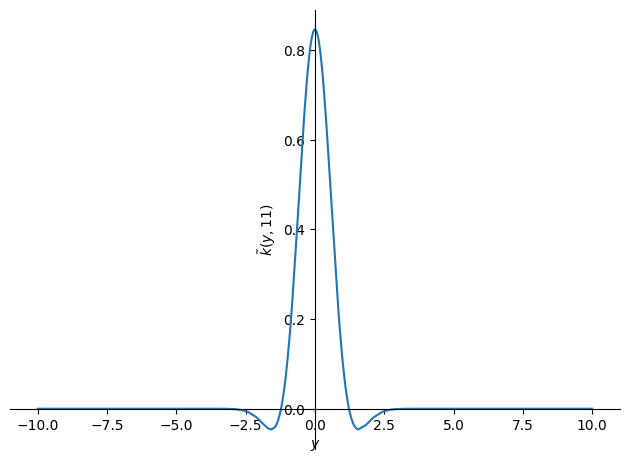

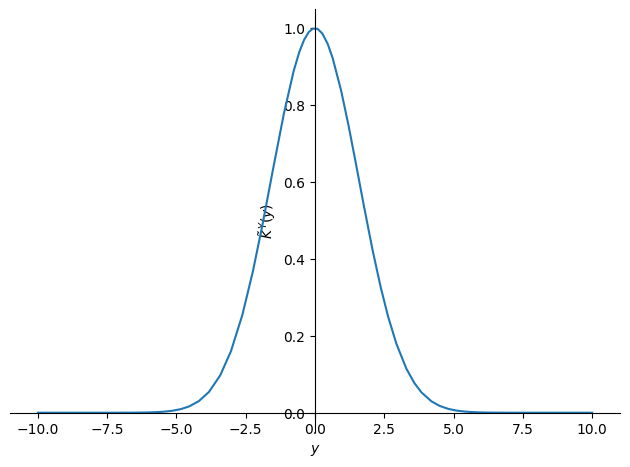

pi**(1/4)*(-2*h**4*z**2 + 3*h**4 + 10*sqrt(2)*sqrt(pi)*h**2 + 16*pi)*exp(z**2*(-1 + 4*sqrt(pi)/(sqrt(2)*h**2 + 4*sqrt(pi))))/(sqrt(sqrt(2)*h**2 + 4*sqrt(pi))*(h**4 + 4*sqrt(2)*sqrt(pi)*h**2 + 8*pi))


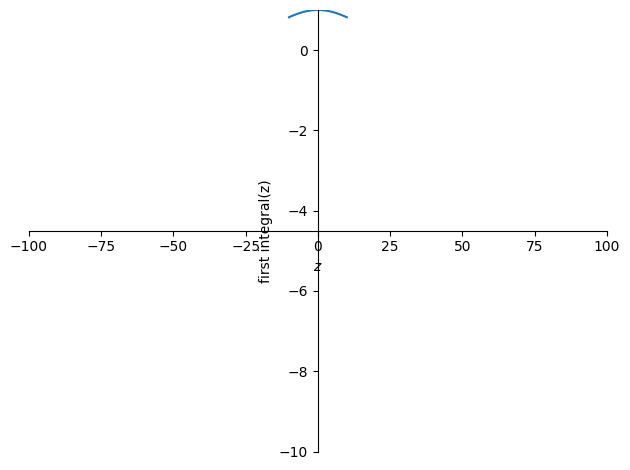

0.450281397058513


In [13]:
h = sy.symbols('h',positive = True)
ktilde = sy_hermite_kernel(y,h,2) #density kernel
hval = 1
sy.plot(ktilde.subs(h,hval),ylabel = r'$\tilde k(y,'+str(hval)+'1)$')
KYtilde = sy.exp(-y**2/2/(sy.sqrt(2*sy.pi))) #reproducing kernel
sy.plot(KYtilde,ylabel = r'$\tilde K^Y(y)$')
integone = sy.simplify(sy.integrate(ktilde.subs(h,1) * KYtilde.subs(y,(y-z)*h),(y,-sy.oo,sy.oo)))
print(integone)
sy.plot(integone.subs(h,1/10),ylabel = 'first integral(z)', xlim = [-100,100], ylim=[-10,1]);
print(sy.N(integone.subs([(h,1/10), (z,20)])))
#print(sy.N(integone))
#kqual = sy.simplify(KYtilde.subs(y,0) - 2*sy.integrate(ktilde * KYtilde.subs(y,y*h),(y,-sy.oo,sy.oo)) \
#    + sy.integrate(integone * ktilde.subs(y,z),(z,-sy.oo,sy.oo)))
#print(kqual)

In [14]:
print(sy.N(integone.subs([(h,1/10), (z,1000)])))

-8.00880907842049e-865


In [15]:
wt = sy.exp(-z*z/2)
#partial = sy.integrate((-sy.sqrt(2)*h**4*z**2 + 7*sy.sqrt(2)*h**4/4 + 5*sy.sqrt(sy.pi)*h**2 ) * wt,(z,-sy.oo,sy.oo))
partial = sy.integrate((sy.exp(z**2*(-1/2 + sy.sqrt(sy.pi)/(sy.sqrt(2)*h**2 + 2*sy.sqrt(sy.pi))))) * wt,(z,-sy.oo,sy.oo))
print(partial)

sqrt(2)*sqrt(pi)/sqrt(1 - 2*polar_lift(-0.5 + sqrt(pi)/(sqrt(2)*h**2 + 2*sqrt(pi))))


In [16]:
sy.plot(kqual, (h,0.01,10), xscale = 'log', yscale = 'log', ylabel = 'Smoothing Quality', axis_center = (0.008,1e-9));

NameError: name 'kqual' is not defined

## Numeric Isotropic Kernels

### Define Hermite kernels

In [154]:
def hermite_kernel(y, r = 1):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array(sy.N(sy_hermite_kernel(r = r, only_coef = True)))
    print(coef)
    poly = sp.special.hermite(0)
    print(poly)
    k = sp.special.hermite(0)(y)*coef[0] #initialize a vector of kernel values
    print(k)
    for ii in range(1,r):
        k += sp.special.hermite(2*ii)(y)*coef[ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [18]:
y = np.linspace(-1,2,5)
print('y =',y)
print(type(y))
k = hermite_kernel(y)
print('k =',k)

y = [-1.   -0.25  0.5   1.25  2.  ]
<class 'numpy.ndarray'>
[[0.564189583547756]]
 
1
[0.564189583547756 0.564189583547756 0.564189583547756 0.564189583547756
 0.564189583547756]
k = [0.342198280312217 0.546831294919853 0.497895559951388 0.258304813712196
 0.0763547570885822]


## Experiment with KDE

### Generate some $x$ points

In [19]:
d = 3
coord_wts = 2.**(-np.array(range(0,d)))
print(coord_wts)
n = 2**12
iidpts = qp.IIDStdUniform(d).gen_samples(n)
print("iid pts",iidpts)
wtiidpts = np.multiply(iidpts,coord_wts)
print(wtiidpts)
sobpts = qp.Sobol(d).gen_samples(n)
print("sobol pts",sobpts)

[1.   0.5  0.25]
iid pts [[0.65114913 0.57858707 0.98350886]
 [0.48557053 0.1235619  0.51953297]
 [0.56613323 0.92359004 0.36788396]
 ...
 [0.62562997 0.19118199 0.87024112]
 [0.51425423 0.86821595 0.78736345]
 [0.87860973 0.25222022 0.81115308]]
[[0.65114913 0.28929354 0.24587722]
 [0.48557053 0.06178095 0.12988324]
 [0.56613323 0.46179502 0.09197099]
 ...
 [0.62562997 0.095591   0.21756028]
 [0.51425423 0.43410798 0.19684086]
 [0.87860973 0.12611011 0.20278827]]
sobol pts [[0.70381125 0.44157536 0.18482637]
 [0.27999504 0.95027103 0.85252769]
 [0.78139361 0.5836286  0.55578029]
 ...
 [0.42342239 0.5463968  0.55730638]
 [0.88967518 0.92890838 0.85478957]
 [0.06349139 0.43559381 0.1864774 ]]


### Generate some $y=f(x)$ points

In [20]:
def testfun(x,coord_wts = 1):
    wtx = np.multiply(x,coord_wts)
    y = 10*np.exp(-wtx.sum(1))*np.sin(np.pi*wtx.sum(1))
    return y

In [21]:
yiid = testfun(iidpts)
ysob = testfun(sobpts)

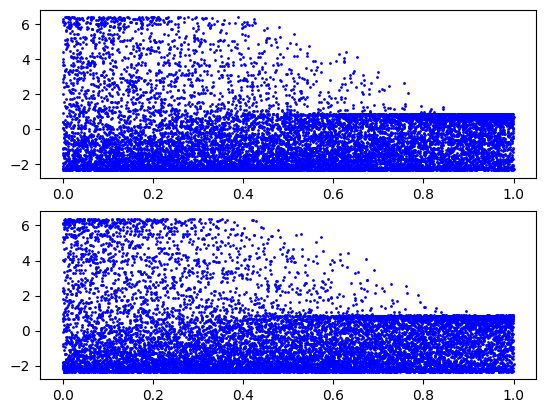

In [22]:
fig,ax = plt.subplots(2)
ax[0].plot(iidpts, yiid, 'b.', markersize = 2)
ax[1].plot(sobpts, ysob, 'b.', markersize = 2);

### Compute the scipy kernel density estimator

In [23]:
def scipy_kde(data,where_to_evaluate):
    density_estimate = stats.gaussian_kde(data.T)
    kdevalues = density_estimate(where_to_evaluate)
    return kdevalues, density_estimate    
    #return density_estimate

In [24]:
right = np.max(ysob)
left = np.min(ysob)
step = (right-left)/500
xvalues = np.arange(left,right,step)
small_n = int(np.sqrt(n))

In [25]:
kdeiidsmall, trash = kde(yiid[:small_n],xvalues)
print('small_n',small_n)
print('kdeiidsmall',kdeiidsmall[:10])
kdeiid, trash = kde(yiid,xvalues)
kdesobsmall, trash = kde(ysob[:small_n],xvalues)
kdesob, trash = kde(ysob,xvalues)

NameError: name 'kde' is not defined

NameError: name 'kdeiid' is not defined

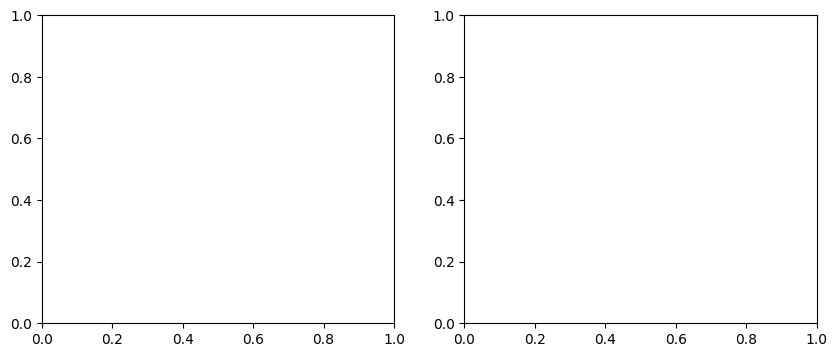

In [26]:
fig,ax = plt.subplots(1,ncols=2,figsize = (10,4))
for ii in range(2):
#    ax[ii].plot(xvalues, stats.norm.pdf(xvalues), 'k-', linewidth = 2);
    ax[ii].plot(xvalues, kdeiid, 'b-', linewidth = 2)
    ax[ii].plot(xvalues, kdeiidsmall, 'g-', linewidth = 2)
    ax[ii].plot(xvalues, kdesob, 'c-', linewidth = 2)
    ax[ii].plot(xvalues, kdesobsmall, 'm-', linewidth = 2);
ax[1].set_yscale('log')

### Compute the vanilla kernel density estimator

In [27]:
def vanilla_kde(data,where_to_evaluate,kernel = hermite_kernel(),band_width = 1):
    density_estimate = lambda y : kernel((y - data.T)/band_width).mean(1)
    kdevalues = density_estimate(where_to_evaluate)
    return kdevalues, density_estimate    
    #return density_estimate

TypeError: hermite_kernel() missing 1 required positional argument: 'y'

## Decomposition

In [39]:
x1, x2 = sy.symbols('x1 x2')
f = x2*sy.cos(x1) - 3*x1
fnull = f.subs([(x1,sy.S(1)/2),(x2,sy.S(1)/2)])
f1 = f.subs(x2,sy.S(1)/2) - fnull
f2 = f.subs(x1,sy.S(1)/2) - fnull
f12 = f - f1 - f2 - fnull
print(f)
print(fnull)
print(f1)
print(f2)
print(f12)

-3*x1 + x2*cos(x1)
-3/2 + cos(1/2)/2
-3*x1 + cos(x1)/2 - cos(1/2)/2 + 3/2
x2*cos(1/2) - cos(1/2)/2
x2*cos(x1) - x2*cos(1/2) - cos(x1)/2 + cos(1/2)/2


0.3333333333333333
